In [19]:
__author__ = 'eribeiro'
#
import numpy as np               # Numpy library
from PIL import Image as im      # Basic image processing library 

In [20]:
class Ray:
    """A class representing a ray (line in space). 
    
    Uses the parametric representation of a line, p(t) = e + (s - e)*t.
    
    The ray passes through the following two points: 

    e = [e_u, e_v, e_w] representing the eye location in 3-D, and      
    s = [e_u, e_v, e_w] representing a point on the image plane.

    Attributes:
        e: 3x1 np.array, e.g., 
        s: 3x1 np.array 
    """

    # Properties
    e = np.zeros((3, 1))  # Starting point
    s = np.zeros((3, 1))  # Starting point

    def __init__(self, e, s):
        """Constructor method

        Args:
            e (3x1 np.array): Eye location
            s (3x1 np.array): Point on the image plane
        """
        self.e = e   
        self.s = s   


    def get3DPoint(self, t):        
        """Calculates the location of a 3-D point along the ray given t.

        Args:
            t (float): Parameter of the ray equation
        Returns:
            p (3x1 nd.array): Point p(t) = e + (s - e) * t.
        """
        p = self.e + (self.s - self.e) * t    # p(t) = e + (s - e) * t
        
        return p
    

In [21]:
class Sphere:
    """A class representing a Sphere.

    Attributes:
        Center (3x1 np.ndarray): Center of the sphere in 3-D
        Radius (float): Radius of the sphere
        Color (3x1 np.ndarray): (Solid) Color of the sphere's surface Color = [ red, green, blue]
    """
    
    def __init__(self, c, r, k):
        """Constructor method

        Args:
            c (3x1 np.ndarray): Center 
            r (float): Radius
            k (3x1 np.ndarray): Color [red, green, blue], each component is in the [0,255] range            
        """
        self.Center = c
        self.Radius = r
        self.Color = k

    def Intersect(self, ray):
        """Calculates the intersection of this sphere and the ray provided as input

        Args:
            ray (Ray object)  p(t) = e + (s - e) * t
        Returns:
            t (float): distance (line parameter) from the eye to the intersection point along the ray
        """
        # ray: ray object  p(t) = e + (s - e) * t

        # For calculations, I prefer to use the notation
        # similar to the one in the slides or associated paper.
        d = ray.s - ray.e  # Direction of the ray
        e = ray.e          # Ray's starting point

        c = self.Center  # Sphere center
        r = self.Radius  # Sphere radius

        # Check whether the ray intersects the sphere
        A = np.dot(d, d)
        B = 2.0 * np.dot(d, (e - c))
        C = np.dot((e - c), (e - c)) - r * r

        #delta = B*B - A * C
        delta = B*B - 4.0 * A * C
        if delta < 0:
            return float("inf")         # Ray didn't intersect sphere
        else:
            # Compute value of parameter t at the intersection point
            t1 = (-B - np.sqrt(delta)) / (2.0 * A)
            t2 = (-B + np.sqrt(delta)) / (2.0 * A)

            # We are interested only in the closest intersection.
            # We take the smaller t
            t = np.min([t1, t2])
            
            return t

In [22]:
class Plane:
    """A class representing a plane. 

    The components of the plane equation are: 
    
    - A point on the plane
    - The planes normal vector (i.e., a normalized vector perpendicular to the plane)
    - The color (flat/solid) of the plane (RGB)

    Attributes:
        p1 (3x1 np.ndarray): any point on the plane        
        n (3x1 np.ndarray): the normalized vector that perpendicular to the plane
        Color (3x1 np.ndarray): the plane's color
    """
    def __init__(self, p1, n, k):
        """Constructor method

        Args:
            p1 (3x1 np.ndarray): Point on the plane 
            n (3x1 np.ndarray): Plane's normal vector
            k (3x1 np.ndarray): Color [red, green, blue], each component is in the [0,255] range            
        """
        self.p1    = p1
        self.n     = n 
        self.Color = k

    def Intersect(self, ray):
        """Calculates the intersection of this plane and the ray provided as input

        Args:
            ray (Ray object)  p(t) = e + (s - e) * t
        Returns:
            t (float): distance (line parameter) from the eye to the intersection point along the ray
        """
        # Check if the ray and the plane are parallel

        d = (ray.s - ray.e) @ self.n
        if abs(d) < 1e-6:
            return None

        # Calculate the distance from the eye to the plane
        t = (self.p1 - ray.e) @ self.n 
        t = t/d

        # Check if the intersection is in front of the eye
        if t < 0:
            return None
         
            
        return t  
    

In [23]:
class Camera:
    """A class representing the camera.
    
    This camera consists of the focal length, the image matrix, and functions 
    that convert pixel coordinates to geometric (u,v,w)-coordinates. 

    Attributes:
        f (float): Camera's focal distance
        
        nrows (int): Image horizontal resolution in pixels 
        ncols (int): Image vertical resolution in pixels 
        I (np.ndarray of size nrows x ncols)
    """
    nchannels = 3    # channels (RGB)
    
    def __init__(self, f, nrows, ncols):
        # f: Focal distance 
        self.f = f         
        self.nrows = nrows    # Image resolution in pixels 
        self.ncols = ncols

        # Initialize image matrix 
        self.I = np.zeros([self.nrows, self.ncols, self.nchannels])

    'Ray-sphere intersection. It returns the smallest t. '
    def ij2uv(self, i, j):
        u =  (j + 0.5) - self.ncols/2 
        v = -(i + 0.5) + self.nrows/2
        
        return u,v

    def constructRayThroughPixel(self, i, j):
        # Construct ray through pixel (i,j)
        u,v = self.ij2uv(i, j)
        s = np.array((u, v, -self.f)).transpose()
        ray = Ray(e, s)                        

        return ray
    


In [24]:
class HitInformation:
    """A class representing the all the information of objects intersected by a given ray.

    Attributes:
        Object (python class of object): e.g., sphere, cylinder, cone, plane
        
        p (3x1 np.ndarray): 3-D coordinates of the intersection point 
    """
    def __init__(self, intersected_object, intersecton_point,normal_point):
        self.Object = intersected_object
        self.p = intersecton_point
        self.n = normal_point
        
     

In [28]:
class Scene: 
    """A class representing the whole scene, i.e., objects in the scene.

    I wanted Scene to consist of the entire scene that consists of 
    all objects (e.g., spheres, planes, triangles, cilinders). 
    
    Here is just a preliminary attempt of implementing a list of objects.         

    Attributes:
        Object (python class of object): e.g., sphere, cylinder, cone, plane
        
        p (3x1 np.ndarray): 3-D coordinates of the intersection point 
    """
    def __init__(self):
        # I simply implement this class as a list of geometrical objects. 
        list = []
        
        # Object 1
        Center = np.array((-90, 0, -400.0)).transpose()
        Radius = 80.0
        Color = np.array((255, 0, 0)).transpose()        
        list.append(Sphere(Center, Radius, Color))
        
        # Object 2
        Center = np.array((90, 0, -400.0)).transpose()
        Radius = 80.0
        Color = np.array((0, 255, 0)).transpose()                    
        list.append(Sphere(Center, Radius, Color))
        
        # Create a plane
        p1 = np.array([0, 0, -200]).transpose()
        n = np.array([0, 0, 1]).transpose()
        pln = Plane(p1, n, np.array([0, 0, 255]))
        list.append(pln)

        # List of objects in the scene 
        self.scene_objects = list
           
    def find_intersection(self, ray):
        """Intersects the ray with the scene (all objects in the scene)

        Args:
            ray (Ray object)  p(t) = e + (s - e) * t
        Returns:
            hit (python list): list with the information about the hits.
        """
        hit = []        # List of intersections (location and object intersected)
        for surface in self.scene_objects: 
            t = surface.Intersect(ray)                  # t parameter at intersection point
            if float('inf') != t:                       # Does the ray intersects the surface? 
                p = ray.get3DPoint(t)                   # (u,v,w) coordinates of intersection point
                if type(surface) == Sphere:             # If the surface is a sphere
                    N = (p - surface.Center) / surface.Radius
                else:                                   # If the surface is a plane
                    N = surface.n
                hitInfo = HitInformation(surface, p, N)
                hit.append(hitInfo)                        # We might need more attributes...

        return hit     # List with the information about the hits

    def get_color(self, hit, light, eye):
        """Returns the color seen by the visual ray using the Phong reflection model.
        """
        pixelColor = np.array((0.0, 0.0, 0.0)).transpose()  # Initial color is black               
        for objectAttribute in hit:                   # Loop through hits             
            object_color = objectAttribute.Object.Color # Color of the intersected object (at the intersection point)

            # Calculate ambient component
            ambient = 0.1 *object_color

            # Calculate diffuse component       
            N = objectAttribute.n # Surface normal at intersection point
            L = light.p - objectAttribute.p                        # Direction to light source from intersection point
            L = L / np.linalg.norm(L)                              # Normalize direction to light source
            diffuse = object_color * max(np.dot(N, L), 0.0)

            # Calculate specular component
            V = eye - objectAttribute.p                      # Direction to viewer from intersection point
            V = V / np.linalg.norm(V)                        # Normalize direction to viewer
            R = 2 * np.dot(N, L) * N - L                      # Reflection direction of light at intersection point
            R = R / np.linalg.norm(R)                        # Normalize reflection direction
            specular = np.array((255, 255, 255)).transpose() * pow(max(np.dot(V, R), 0.0), 32)

            # Calculate total color
            pixelColor += ambient + diffuse + specular
    
        return pixelColor/len(self.scene_objects)   # Average color

    

In [29]:
class PointLight:
    """Class to represent a point light source"""
    def __init__(self, position, color):
        self.p = position
        self.color = color

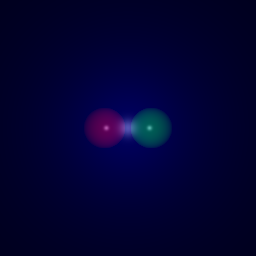

In [30]:
# Create camera (and image resolution)
nrows = 256
ncols = 256
# Set focal distance
f = 100

# Create a ray
e = np.array((0.0, 0.0, 0.0)).transpose()

myCamera = Camera(f, nrows, ncols)

# Create the scene (collection of objects - hardcoded for simplicity)
theScene = Scene()

# Loop through all pixels (i,j) in the image matrix 
for i in range(nrows): 
    for j in range(ncols):
        # Construct the ray between between the eye and s = (u, v, -f)       
        ray = myCamera.constructRayThroughPixel(i, j)
        
        # Intersect the ray with the scene (all objects in the scene)
        hit = theScene.find_intersection(ray)   
        
        # Set the pixel color 
        light = PointLight(np.array([0, 0, -100]), np.array([1, 1, 1]))
        myCamera.I[i,j,:] = theScene.get_color(hit, light, e)
                
       
        
# Create an image from an array (display image and save file)
out_image = im.fromarray(np.uint8(myCamera.I))
display(out_image)
out_image.save('raytraced_scene_finish.png')